In [1]:
import sys
sys.path.append('../py')

from nb_imports import *
from model_params import model_parms,do_not_use_for_training
from modelling import FeatureExtract

from sklearn.externals.joblib import Memory
from tempfile import mkdtemp
# Create a temporary folder to store the transformers of the pipeline
cachedir = mkdtemp(dir='/mnt/temp')
memory = Memory(cachedir=cachedir, verbose=0)

import lightgbm as lgb

In [2]:
seed = int(str(time.time()).split('.')[1]) * 2 + int(str(time.time()).split('.')[0]) % 3
rns = [random.randint(0, 1<<31) for i in range(10)]    
seed

valid_split = KFold(n_splits=4, shuffle=True, random_state=rns[0])
test_split = KFold(n_splits=4, shuffle=True, random_state=rns[1])

train_data = pd.read_parquet('../data/train_basic3.parquet')
train_data.columns = train_data.columns.str.lower()
test_data = pd.read_parquet('../data/test_basic3.parquet')
test_data.columns = test_data.columns.str.lower()

In [16]:
nn_density = pd.read_csv('../features/path_expand/nn_count.csv', header=None).rename(columns={0:'id'})

In [17]:
nn_density

id    1  2  3   4   5   6   7   8   9  10  11
0            1   49  1  2   2   3   3   4   4   4   4   4
1            2   92  0  0   0   1   2   3   3   4   4   4
2            3   67  1  3   3   5   6   6   9  11  13  14
3            4   98  1  1   1   1   4   7  12  13  14  17
4            5   92  0  0   0   0   0   2   2   8  11  17
5            6  118  0  2   3   8  11  14  15  18  21  27
6            7   84  0  0   4   4   7   8   9  15  16  17
7            8   86  0  1   3   5   6   7  10  10  11  16
8            9   62  0  0   0   1   2   2   2   2   2   2
9           10   26  0  1   1   2   4   5   5   7   8  11
10          11   79  0  0   0   0   0   0   0   0   0   0
11          12   99  0  2   2   3   7   9  14  18  23  25
12          13    5  2  2   2   3   3   3   3   3   3   3
13          14   94  1  1   2   3   6   9  10  13  20  21
14          15   78  1  3   3   3   5   5   5   6  10  11
15          16   24  0  0   0   0   0   0   0   0   0   0
16          17   23  1  1   1   1   1   1   1   1   2   2
17          18   73  1  1   1   2   2   3   4   6   8  11
18          19   49  1  1   1   1   1   1   3   3   4   4
19          20   54  0  0   1   1   1   4   6   7   9  10
20          21   60  0  0   2   5   7   8  10  14  16  17
21          22   95  1  3   7   9  15  18  26  30  33  37
22          23   86  1  2   4   6   7  11  14  18  19  21
23          24   33  0  0   0   0   1   1   1   1   1   1
24          25  110  2  9  16  23  25  29  34  38  43  46
25          26   99  1  1  11  15  19  20  22  26  30  32
26          27   53  0  1   1   2   4   8   9   9  10  10
27          28   48  1  1   1   3   4   4   5   6   7   9
28          29  106  0  0   0   0   0   0   0   0   0   0
29          30  106  1  2   5   6  12  14  16  17  17  19
...        ...  ... .. ..  ..  ..  ..  ..  ..  ..  ..  ..
930314  930315   56  0  0   1   1   1   1   1   1   3   5
930315  930316   26  0  0   0   0   1   1   1   1   1   2
930316  930317   33  0  0   1   1   1   1   2   5   5   5
930317  930318   44  0  0   0   0   0   0   1   1   1   1
930318  930319   67  0  0   0   0   0   0   0   0   0   0
930319  930320   24  0  0   0   0   0   0   0   1   4   5
930320  930321   16  0  0   0   1   1   1   1   2   5   6
930321  930322   48  1  1   2   3   3   3   3   4   5   6
930322  930323  109  0  2   3   5   7   8  11  15  23  25
930323  930324   27  0  0   0   0   1   1   2   4   5   6
930324  930325   69  0  0   0   0   0   0   2   3   3   5
930325  930326   20  1  2   2   3   4   4   5   5   6   7
930326  930327   82  0  1   1   1   2   3   3   3   4   4
930327  930328   46  1  1   1   2   2   3   3   3   3   3
930328  930329   10  0  0   0   0   0   0   0   0   1   1
930329  930330   56  1  1   2   2   2   3   3   4   4   5
930330  930331   14  0  0   0   0   0   0   0   0   1   1
930331  930332   71  0  0   0   0   1   1   2   3   3   5
930332  930333   11  0  0   0   0   0   0   0   0   0   0
930333  930334   78  0  0   0   1   1   2   2   2   4   4
930334  930335   14  0  0   0   0   0   0   1   1   1   1
930335  930336   97  0  0   0   0   0   0   0   0   1   2
930336  930337   84  0  0   0   1   2   3   3   7  10  13
930337  930338   87  2  3   4   8  10  11  12  13  14  14
930338  930339   27  1  1   1   1   2   4   4   4   4   4
930339  930340   83  0  0   0   0   0   1   1   1   1   1
930340  930341   58  0  0   0   0   0   4   5   7   9  11
930341  930342   85  1  1   1   1   1   3   3   3   6   7
930342  930343   60  1  2   4   6  12  15  16  16  20  20
930343  930344   48  0  0   1   1   1   4   7   7   8   9

[930344 rows x 12 columns]

In [5]:
def log_transform(x):
    return np.log1p(x)
def inv_log_transform(x):
    return np.expm1(x)

def mspe_eval(preds, dtrain, transform_f=None):
    _preds = preds
    if type(dtrain) ==  xgb.core.DMatrix:
        labels = dtrain.get_label()
    elif type(dtrain) ==  lgb.Dataset:
        labels = dtrain.get_label()
    else:
        labels = dtrain
    if transform_f is not None:
        labels = transform_f(labels)
        _preds = transform_f(_preds)
    # return a pair metric_name, result
    # since preds are margin(before logistic transformation, cutoff at 0)
    if type(dtrain) ==  lgb.Dataset:
        return 'mspe', \
            (sum((((_preds)-(labels))/(labels)) ** 2) / len(labels))**0.5, False
    return 'mspe', \
        (sum((((_preds)-(labels))/(labels)) ** 2) / len(labels))**0.5

def score_func(y, y_pred):
    return mspe_eval(y_pred, y, transform_f=inv_log_transform)[1]

mspe_scorer = make_scorer(score_func, greater_is_better=False)

def mspe_log(preds, dtrain):
    return mspe_eval(preds, dtrain, inv_log_transform)

from sklearn.externals import joblib

def get_cv_scores(len_pipe, dur_pipe):
    scores = []
    for fold in test_split.split(train_data):
        len_pipe.fit(train_data.iloc[fold[0]],
                                       np.log1p(train_data['traj_length'])[fold[0]]);
        dur_pipe.fit(train_data.iloc[fold[0]],
                                       np.log1p(train_data['duration'])[fold[0]]);

        len_ptr = len_pipe.predict(train_data.iloc[fold[0]])
        dur_ptr = dur_pipe.predict(train_data.iloc[fold[0]])

        ytr_pred = inv_log_transform(len_ptr) + inv_log_transform(dur_ptr)
        ytr = train_data['traj_length'][fold[0]] + train_data['duration'][fold[0]]
        print('training_score %s' % mspe_eval(ytr_pred, ytr, transform_f=None)[1])

        len_pv = len_pipe.predict(train_data.iloc[fold[1]])
        dur_pv = dur_pipe.predict(train_data.iloc[fold[1]])
        yv_pred = inv_log_transform(len_pv) + inv_log_transform(dur_pv)
        yv = train_data['traj_length'][fold[1]] + train_data['duration'][fold[1]]
        scores.append(mspe_eval(yv_pred, yv, transform_f=None))
        print('valid_score %s' % mspe_eval(yv_pred, yv, transform_f=None)[1])
    return scores

## ERF
et_len_pipe = Pipeline([
    ('fe', FeatureExtract(do_not_use_for_training, verbose=0, training=True)),
    ('imp', Imputer(strategy='median')),
    ('ss', StandardScaler()),
    ('et', ExtraTreesRegressor(n_estimators=50, max_features=0.8, min_samples_split=25,
                               min_samples_leaf=5,
                                 max_depth=50, bootstrap=True, oob_score=True, 
                               n_jobs=NUM_CORES))
], memory=memory)
et_dur_pipe = Pipeline([
    ('fe', FeatureExtract(do_not_use_for_training, verbose=0, training=True)),
    ('imp', Imputer(strategy='median')),
    ('ss', StandardScaler()),
    ('et', ExtraTreesRegressor(n_estimators=50, max_features=0.8, min_samples_split=25,
                               min_samples_leaf=5,
                                 max_depth=50, bootstrap=True, oob_score=True, 
                               n_jobs=NUM_CORES)),
], memory=memory)

## RF
rf_len_pipe = Pipeline([
    ('fe', FeatureExtract(do_not_use_for_training, verbose=0, training=True)),
#     ('ss', StandardScaler()),
    ('imp', Imputer(strategy='median')),
    ('rf', RandomForestRegressor(n_estimators=100, max_features='sqrt',
                                 max_depth=60, n_jobs=NUM_CORES))
], memory=memory)

rf_dur_pipe = Pipeline([
    ('fe', FeatureExtract(do_not_use_for_training, verbose=0, training=True)),
#     ('ss', StandardScaler()),
    ('imp', Imputer(strategy='median')),
    ('rf', RandomForestRegressor(n_estimators=100, max_features='sqrt',
                                 max_depth=50, n_jobs=NUM_CORES)),
], memory=memory)



## XGB

xgb_len_pipe = Pipeline([
    ('fe', FeatureExtract(do_not_use_for_training, verbose=0, training=True)),
    ('xgbr', xgb.XGBRegressor(**model_parms['len_xgb'])),
], memory=memory)
xgb_dur_pipe = Pipeline([
    ('fe', FeatureExtract(do_not_use_for_training, verbose=0, training=True)),
    ('xgbr', xgb.XGBRegressor(**model_parms['dur_xgb'])),
], memory=memory)

# LGB
lgb_len_pipe = Pipeline([
    ('fe', FeatureExtract(do_not_use_for_training, verbose=0)),
    ('xgbr', lgb.LGBMRegressor(**model_parms['len_lgb'])),
], memory=memory)
lgb_dur_pipe = Pipeline([
    ('fe', FeatureExtract(do_not_use_for_training, verbose=0)),
    ('xgbr', lgb.LGBMRegressor(**model_parms['dur_lgb'])),
], memory=memory)


class Ensemble(BaseEstimator, TransformerMixin, RegressorMixin):
    def __init__(self, predictor, training=True, **kwargs):
        self.predictor = predictor
        if predictor == 'dur':
            self.xgb = xgb_dur_pipe
            self.et = lgb_dur_pipe
        else:
            self.xgb = xgb_len_pipe
            self.et = lgb_len_pipe
    
    def fit(self, X, y):
        self.et.fit(X, y)
        self.xgb.fit(X, y)
        return self
        
    def predict(self, X):
        y1 = self.et.predict(X)
        y2 = self.xgb.predict(X)
        return (y1 + y2) / 2
    
    def get_params(self, **kwargs):
        return {'predictor': self.predictor}

# scores = get_cv_scores(Ensemble('len'), Ensemble('dur'))

# print(scores)
# open(f'../{seed}_cv_scores.txt', 'w').write(str(scores))

In [6]:
scores = get_cv_scores(Ensemble('len'), Ensemble('dur'))

/home/chenghang/miniconda3/lib/python3.6/site-packages/sklearn/base.py:115: DeprecationWarning: Estimator FeatureExtract modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
/home/chenghang/miniconda3/lib/python3.6/site-packages/sklearn/base.py:115: DeprecationWarning: Estimator FeatureExtract modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
/home/chenghang/miniconda3/lib/python3.6/site-packages/sklearn/base.py:115: DeprecationWarning: Estimator FeatureExtract modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
/home/chenghang/miniconda3/lib/python3.6/site-packages/sklearn/base.py:115: DeprecationWarning: Estimator 

training_score 0.19849545637611127


../py/modelling.py:62: RuntimeWarning: invalid value encountered in log1p
  X[f'log_{col}'] = np.log1p(X[col])


valid_score 0.2141382952784894


/home/chenghang/miniconda3/lib/python3.6/site-packages/sklearn/base.py:115: DeprecationWarning: Estimator FeatureExtract modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
/home/chenghang/miniconda3/lib/python3.6/site-packages/sklearn/base.py:115: DeprecationWarning: Estimator FeatureExtract modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
/home/chenghang/miniconda3/lib/python3.6/site-packages/sklearn/base.py:115: DeprecationWarning: Estimator FeatureExtract modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
/home/chenghang/miniconda3/lib/python3.6/site-packages/sklearn/base.py:115: DeprecationWarning: Estimator 

training_score 0.19850269215832253


../py/modelling.py:62: RuntimeWarning: invalid value encountered in log1p
  X[f'log_{col}'] = np.log1p(X[col])


valid_score 0.21256997423963128


/home/chenghang/miniconda3/lib/python3.6/site-packages/sklearn/base.py:115: DeprecationWarning: Estimator FeatureExtract modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
/home/chenghang/miniconda3/lib/python3.6/site-packages/sklearn/base.py:115: DeprecationWarning: Estimator FeatureExtract modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
/home/chenghang/miniconda3/lib/python3.6/site-packages/sklearn/base.py:115: DeprecationWarning: Estimator FeatureExtract modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
/home/chenghang/miniconda3/lib/python3.6/site-packages/sklearn/base.py:115: DeprecationWarning: Estimator 

training_score 0.19839416424978693


../py/modelling.py:62: RuntimeWarning: invalid value encountered in log1p
  X[f'log_{col}'] = np.log1p(X[col])


valid_score 0.2144012049717886


/home/chenghang/miniconda3/lib/python3.6/site-packages/sklearn/base.py:115: DeprecationWarning: Estimator FeatureExtract modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
/home/chenghang/miniconda3/lib/python3.6/site-packages/sklearn/base.py:115: DeprecationWarning: Estimator FeatureExtract modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
/home/chenghang/miniconda3/lib/python3.6/site-packages/sklearn/base.py:115: DeprecationWarning: Estimator FeatureExtract modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
/home/chenghang/miniconda3/lib/python3.6/site-packages/sklearn/base.py:115: DeprecationWarning: Estimator 

training_score 0.19839755303280182


../py/modelling.py:62: RuntimeWarning: invalid value encountered in log1p
  X[f'log_{col}'] = np.log1p(X[col])


valid_score 0.21199852465291352


In [9]:
np.mean([s[1] for s in scores])

0.2132769997857057

In [37]:
boosters = []
for fold in test_split.split(train_data):
    fe = FeatureExtract(do_not_use_for_training, verbose=0)
    fe.fit(train_data.iloc[fold[0]]);
    Xtr = fe.transform(train_data.iloc[fold[0]])
    ytr = np.log1p(train_data['traj_length'])[fold[0]]
    Xv = fe.transform(train_data.iloc[fold[1]])
    yv = np.log1p(train_data['traj_length'])[fold[1]]
    
    et = ExtraTreesRegressor(n_estimators=50, max_features=0.8, min_samples_split=25,
                               min_samples_leaf=5,
                                 max_depth=50, bootstrap=True, oob_score=True, 
                               n_jobs=NUM_CORES, warm_start=True)

    min_estimators = 75
    max_estimators = 1000

    error_rate = {}

    for i in range(min_estimators, max_estimators + 1, 4):
        et.set_params(n_estimators=i)
        et.fit(Xtr, ytr)

        oob_error = 1 - et.oob_score_
        error_rate[i] = oob_error
        print(i, oob_error)
    break

../py/modelling.py:62: RuntimeWarning: invalid value encountered in log1p
  X[f'log_{col}'] = np.log1p(X[col])


75 0.2016129545726102
79 0.20149152512884683
83 0.20139983236016346
87 0.2013278354917023
91 0.20123218775674345
95 0.20112629819815142
99 0.20103991899755258
103 0.200992645976935
107 0.20089213817524476
111 0.20080217679970191
115 0.20075297518824153
119 0.2007248304488337
123 0.20067847169596575
127 0.20061768444729566
131 0.2006110423330495
135 0.2005679278727912
139 0.20053260916256188
143 0.20051917310522138
147 0.20048100477519093
151 0.2004635764188336


KeyboardInterrupt: 

In [ ]:
## ERF
et_len_pipe = Pipeline([
    ('fe', FeatureExtract(do_not_use_for_training, verbose=0, training=True)),
    ('imp', Imputer(strategy='median')),
    ('ss', StandardScaler()),
    ('et', )
], memory=memory)
et_dur_pipe = Pipeline([
    ('fe', FeatureExtract(do_not_use_for_training, verbose=0, training=True)),
    ('imp', Imputer(strategy='median')),
    ('ss', StandardScaler()),
    ('et', ExtraTreesRegressor(n_estimators=50, max_features=0.8, min_samples_split=25,
                               min_samples_leaf=5,
                                 max_depth=50, bootstrap=True, oob_score=True, 
                               n_jobs=NUM_CORES, warm_start=True)),
], memory=memory)





In [21]:
boosters = []
for fold in test_split.split(train_data):
    fe = FeatureExtract(do_not_use_for_training, verbose=0)
    fe.fit(train_data.iloc[fold[0]]);
    Xtr = fe.transform(train_data.iloc[fold[0]])
    ytr = np.log1p(train_data['traj_length'])[fold[0]]
    Xv = fe.transform(train_data.iloc[fold[1]])
    yv = np.log1p(train_data['traj_length'])[fold[1]]
    dtrain = xgb.DMatrix(Xtr, label=ytr)
    dval = xgb.DMatrix(Xv, label=yv)

    booster = xgb.train(
        model_parms['len_xgb'], 
        dtrain,
        num_boost_round=100,
        evals=([dtrain, 'tr'], [dval, 'v']), 
        obj=None,
        feval=mspe_log,
        early_stopping_rounds=10,
        verbose_eval=True, xgb_model=None, callbacks=None, learning_rates=None)
    boosters.append(booster)

../py/modelling.py:62: RuntimeWarning: invalid value encountered in log1p
  X[f'log_{col}'] = np.log1p(X[col])


[0]	tr-rmse:4.47436	v-rmse:4.47394	tr-mspe:0.992077	v-mspe:0.992079
Multiple eval metrics have been passed: 'v-mspe' will be used for early stopping.

Will train until v-mspe hasn't improved in 10 rounds.
[1]	tr-rmse:4.11783	v-rmse:4.11759	tr-mspe:0.986567	v-mspe:0.98657
[2]	tr-rmse:3.78992	v-rmse:3.78983	tr-mspe:0.979542	v-mspe:0.979548
[3]	tr-rmse:3.48832	v-rmse:3.48839	tr-mspe:0.970797	v-mspe:0.970808
[4]	tr-rmse:3.21097	v-rmse:3.21116	tr-mspe:0.960166	v-mspe:0.960183
[5]	tr-rmse:2.956	v-rmse:2.95632	tr-mspe:0.947512	v-mspe:0.947533
[6]	tr-rmse:2.7215	v-rmse:2.72195	tr-mspe:0.932772	v-mspe:0.932802
[7]	tr-rmse:2.50592	v-rmse:2.50648	tr-mspe:0.915905	v-mspe:0.915946
[8]	tr-rmse:2.30775	v-rmse:2.30846	tr-mspe:0.896941	v-mspe:0.896994
[9]	tr-rmse:2.12561	v-rmse:2.12647	tr-mspe:0.875952	v-mspe:0.876017
[10]	tr-rmse:1.95827	v-rmse:1.9593	tr-mspe:0.853058	v-mspe:0.853138
[11]	tr-rmse:1.80449	v-rmse:1.80567	tr-mspe:0.82845	v-mspe:0.828545
[12]	tr-rmse:1.66324	v-rmse:1.66459	tr-mspe:0.80232

[55]	tr-rmse:0.242003	v-rmse:0.262145	tr-mspe:0.210447	v-mspe:0.256302
[56]	tr-rmse:0.240908	v-rmse:0.261482	tr-mspe:0.210236	v-mspe:0.257063
Stopping. Best iteration:
[46]	tr-rmse:0.259266	v-rmse:0.276045	tr-mspe:0.215046	v-mspe:0.251687



KeyboardInterrupt: 

In [11]:


boosters = []
for fold in test_split.split(train_data):
    fe = FeatureExtract(do_not_use_for_training, verbose=0)
    fe.fit(train_data.iloc[fold[0]]);
    Xtr = fe.transform(train_data.iloc[fold[0]])
    ytr = np.log1p(train_data['duration'])[fold[0]]
    Xv = fe.transform(train_data.iloc[fold[1]])
    yv = np.log1p(train_data['duration'])[fold[1]]
    lgb_train = lgb.Dataset(Xtr, ytr)
    lgb_eval = lgb.Dataset(Xv, yv, reference=lgb_train)
    booster = lgb.train(model_parms['dur_lgb'], lgb_train, valid_sets=[lgb_train, lgb_eval], feval=mspe_log, early_stopping_rounds=10)
    boosters.append(booster)

../py/modelling.py:62: RuntimeWarning: invalid value encountered in log1p
  X[f'log_{col}'] = np.log1p(X[col])
/home/chenghang/miniconda3/lib/python3.6/site-packages/lightgbm/engine.py:99: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's mspe: 0.292745	valid_1's mspe: 0.311868
Training until validation scores don't improve for 10 rounds.
[2]	training's mspe: 0.274338	valid_1's mspe: 0.290518
[3]	training's mspe: 0.269413	valid_1's mspe: 0.284259
[4]	training's mspe: 0.26711	valid_1's mspe: 0.281741
[5]	training's mspe: 0.265641	valid_1's mspe: 0.280481
[6]	training's mspe: 0.26467	valid_1's mspe: 0.279021
[7]	training's mspe: 0.264441	valid_1's mspe: 0.278375
[8]	training's mspe: 0.264202	valid_1's mspe: 0.278138
[9]	training's mspe: 0.264008	valid_1's mspe: 0.27802
[10]	training's mspe: 0.26398	valid_1's mspe: 0.27811
[11]	training's mspe: 0.263679	valid_1's mspe: 0.277962
[12]	training's mspe: 0.263438	valid_1's mspe: 0.277542
[13]	training's mspe: 0.263404	valid_1's mspe: 0.277598
[14]	training's mspe: 0.263182	valid_1's mspe: 0.277197
[15]	training's mspe: 0.263019	valid_1's mspe: 0.276992
[16]	training's mspe: 0.262867	valid_1's mspe: 0.276879
[17]	training's mspe: 0.262815	valid_1's mspe: 0.276757


KeyboardInterrupt: 

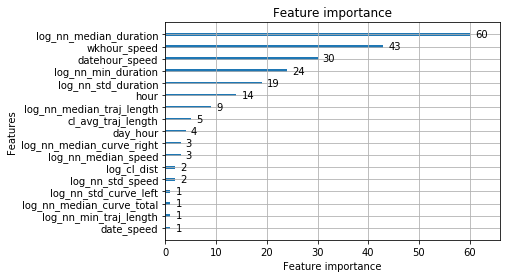

In [8]:
lgb.plot_importance(booster)

In [4]:
len_pipe = Ensemble('len').fit(train_data, np.log1p(train_data['traj_length']))
dur_pipe = Ensemble('dur').fit(train_data, np.log1p(train_data['duration']))

for col in list(train_data.columns):
    if col not in test_data:
        print(col)
        test_data[col] = 0

len_ptr = len_pipe.predict(test_data[train_data.columns])
dur_ptr = dur_pipe.predict(test_data[train_data.columns])
ytr_pred = inv_log_transform(len_ptr) + inv_log_transform(dur_ptr)

/home/chenghang/miniconda3/lib/python3.6/site-packages/sklearn/base.py:115: DeprecationWarning: Estimator FeatureExtract modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
/home/chenghang/miniconda3/lib/python3.6/site-packages/sklearn/base.py:115: DeprecationWarning: Estimator FeatureExtract modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
/home/chenghang/miniconda3/lib/python3.6/site-packages/sklearn/base.py:115: DeprecationWarning: Estimator FeatureExtract modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
/home/chenghang/miniconda3/lib/python3.6/site-packages/sklearn/base.py:115: DeprecationWarning: Estimator 

duration
traj_length
curve_total
curve_left
curve_right
curve_total_ratio
curve_left_ratio
curve_right_ratio
speed


../py/modelling.py:62: RuntimeWarning: invalid value encountered in log1p
  X[f'log_{col}'] = np.log1p(X[col])


In [23]:
# pd.read_csv('../predict/p14.csv', index_col='id').min()

PRICE    183.27504
dtype: float64

In [22]:
# pd.DataFrame(ytr_pred, index=test_data['id'], columns=['PRICE']).max()

PRICE    1406.523267
dtype: float64

In [2]:
# import shutil
# shutil.rmtree(cachedir)
# cachedir = mkdtemp(dir='/mnt/temp')
# memory = Memory(cachedir=cachedir, verbose=0)

NameError: name 'cachedir' is not defined